## 1. Average background subtraction

### 1.1 background image by mean

In [1]:
import cv2
import numpy as np

#1
cap = cv2.VideoCapture('./data/vtest.avi')
if (not cap.isOpened()):
    print('Error opening video')
     
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
              int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))

acc_gray= np.zeros(shape=(height, width), dtype=np.float32)
acc_bgr = np.zeros(shape=(height, width, 3), dtype=np.float32)
t = 0

#2
while True:
    ret, frame = cap.read()
    if not ret:
        break
    t += 1
    if t%50 == 0:
        print('t =', t)   
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    cv2.accumulate(gray, acc_gray)
    avg_gray = acc_gray/t       
    dst_gray = cv2.convertScaleAbs(avg_gray)

    cv2.accumulate(frame, acc_bgr)
    avg_bgr = acc_bgr/t       
    dst_bgr= cv2.convertScaleAbs(avg_bgr)
    
    cv2.imshow('frame',frame)
    cv2.imshow('dst_gray',dst_gray)
    cv2.imshow('dst_bgr',dst_bgr)    
    key = cv2.waitKey(20)
    if key == 27:
        break

#3
if cap.isOpened(): cap.release();
cv2.imwrite('./data/avg_gray.png', dst_gray)
cv2.imwrite('./data/avg_bgr.png', dst_bgr)
cv2.destroyAllWindows()

### 1.2 moving_object detection using background subtraction 

In [2]:
import cv2
import numpy as np

#1
cap = cv2.VideoCapture('./data/vtest.avi')
if (not cap.isOpened()): 
    print('Error opening video')
    
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
              int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))

TH      = 40 # binary threshold
AREA_TH = 80 # area   threshold 
bkg_gray= cv2.imread('./data/avg_gray.png', cv2.IMREAD_GRAYSCALE)
bkg_bgr = cv2.imread('./data/avg_bgr.png')

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE

#2
t = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    t+=1
    if t%50 == 0:
        print('t =', t)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
#2-1 
    diff_gray  = cv2.absdiff(gray, bkg_gray)
##  ret, bImage = cv2.threshold(diff_gray,TH,255,cv2.THRESH_BINARY)
    
#2-2      
    diff_bgr = cv2.absdiff(frame, bkg_bgr)      
    db, dg, dr = cv2.split(diff_bgr)
    ret, bb = cv2.threshold(db,TH,255,cv2.THRESH_BINARY)
    ret, bg = cv2.threshold(dg,TH,255,cv2.THRESH_BINARY)
    ret, br = cv2.threshold(dr,TH,255,cv2.THRESH_BINARY)
 
    bImage = cv2.bitwise_or(bb, bg)
    bImage = cv2.bitwise_or(br, bImage)
      
    bImage = cv2.erode(bImage, None, 5)
    bImage = cv2.dilate(bImage,None, 5)    
    bImage = cv2.erode(bImage, None, 7)

#2-3     
    image, contours, hierarchy = cv2.findContours(bImage, mode, method)
    cv2.drawContours(frame, contours, -1, (255,0,0), 1)   
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area > AREA_TH:
            x, y, width, height = cv2.boundingRect(cnt)
            cv2.rectangle(frame, (x, y), (x+width, y+height), (0,0,255), 2)
    
    cv2.imshow('frame',frame)
    cv2.imshow('bImage',bImage)
    cv2.imshow('diff_gray',diff_gray)
    cv2.imshow('diff_bgr',diff_bgr)
    key = cv2.waitKey(25)
    if key == 27:
        break
#3
if cap.isOpened():
    cap.release();
cv2.destroyAllWindows()

t = 50


### 1.3 moving_object detection using moving average color background subtraction

In [3]:
import cv2
import numpy as np

#1
cap = cv2.VideoCapture('./data/vtest.avi')
if (not cap.isOpened()): 
    print('Error opening video')
     
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                 int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))

TH      = 40 # binary threshold
AREA_TH = 80 # area   threshold 
acc_bgr = np.zeros(shape=(height, width, 3), dtype=np.float32)

mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE

#2
t = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    t+=1
    if t%50 == 0:
        print('t =', t)
    blur = cv2.GaussianBlur(frame,(5,5),0.0)
#2-1
    if t < 50:
        cv2.accumulate(blur, acc_bgr)
        continue
    elif t == 50:
        bkg_bgr = acc_bgr/t
#2-2
#   if t >= 50:

##  diff_bgr = cv2.absdiff(np.float32(blur), bkg_bgr).astype(np.uint8)
    diff_bgr = np.uint8(cv2.absdiff(np.float32(blur), bkg_bgr))
    db,dg,dr = cv2.split(diff_bgr)
    ret, bb = cv2.threshold(db,TH,255,cv2.THRESH_BINARY)
    ret, bg = cv2.threshold(dg,TH,255,cv2.THRESH_BINARY)
    ret, br = cv2.threshold(dr,TH,255,cv2.THRESH_BINARY)
    bImage = cv2.bitwise_or(bb, bg)
    bImage = cv2.bitwise_or(br, bImage)
    bImage = cv2.erode(bImage,None, 5)
    bImage = cv2.dilate(bImage,None,5)    
    bImage = cv2.erode(bImage,None, 7)
    cv2.imshow('bImage',bImage)
    msk = bImage.copy()
    image, contours, hierarchy = cv2.findContours(bImage, mode, method)
    cv2.drawContours(frame, contours, -1, (255,0,0), 1)   
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area > AREA_TH:
            x, y, width, height = cv2.boundingRect(cnt)
            cv2.rectangle(frame, (x, y), (x+width, y+height), (0,0,255), 2)
            cv2.rectangle(msk, (x, y), (x+width, y+height), 255, -1) 
#2-3
    msk = cv2.bitwise_not(msk)
    cv2.accumulateWeighted(blur,bkg_bgr, alpha=0.1,mask=msk)

    cv2.imshow('frame',frame)
    cv2.imshow('bkg_bgr',np.uint8(bkg_bgr))    
    cv2.imshow('diff_bgr',diff_bgr)
    key = cv2.waitKey(25)
    if key == 27:
        break
#3
if cap.isOpened():
    cap.release()
cv2.destroyAllWindows()

t = 50


## 2. Split background and foreground with BackgroundSubtractor

In [4]:
import cv2
import numpy as np

cap = cv2.VideoCapture('./data/vtest.avi')
if (not cap.isOpened()): 
    print('Error opening video')
     
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                 int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))

#1
bgMog1 = cv2.createBackgroundSubtractorMOG2()
bgMog2 = cv2.createBackgroundSubtractorMOG2(varThreshold=25,
                                            detectShadows=False)
bgKnn1 = cv2.createBackgroundSubtractorKNN()
bgKnn2 = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000,
                                           detectShadows=False)

#2
AREA_TH = 80 # area threshold
def findObjectAndDraw(bImage, src):
    res = src.copy()
    bImage = cv2.erode(bImage,None, 5)
    bImage = cv2.dilate(bImage,None,5)    
    bImage = cv2.erode(bImage,None, 7)    
    _, contours, _ = cv2.findContours(bImage,
                      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(src, contours, -1, (255,0,0), 1)
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area > AREA_TH:
            x, y, width, height = cv2.boundingRect(cnt)
            cv2.rectangle(res, (x, y), (x+width, y+height), (0,0,255), 2)
    return res

#3
t = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    t+=1
    if t%50 == 0:
        print('t =', t)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(frame,(5,5),0.0)
#2-1
    bImage1 = bgMog1.apply(blur)
    bImage2 = bgMog2.apply(blur)
    bImage3 = bgKnn1.apply(blur)
    bImage4 = bgKnn2.apply(blur)
    dst1 = findObjectAndDraw(bImage1, frame)
    dst2 = findObjectAndDraw(bImage2, frame)
    dst3 = findObjectAndDraw(bImage3, frame)
    dst4 = findObjectAndDraw(bImage4, frame)

    cv2.imshow('bImage1',bImage1)
    cv2.imshow('bgMog1',dst1)
    cv2.imshow('bImage2',bImage2)
    cv2.imshow('bgMog2',dst2)
    cv2.imshow('bImage3',bImage3)
    cv2.imshow('bgKnn1',dst3)
    cv2.imshow('bImage4',bImage4)
    cv2.imshow('bgKnn2',dst4)
    
    key = cv2.waitKey(25)
    if key == 27:
        break
        
if cap.isOpened():
    cap.release()
cv2.destroyAllWindows()

## 3. Optical flow calculation

### 3.1 cv2.calcOpticalFlowPyrLK(): Track features

In [5]:
import cv2
import numpy as np

#1
roi  = None
drag_start = None
mouse_status = 0
tracking_start  = False

def onMouse(event, x, y, flags, param=None): # Set the region of interest by the mouse event.
    global roi
    global drag_start
    global mouse_status
    global tracking_start   
    if event == cv2.EVENT_LBUTTONDOWN:
        drag_start = (x, y)
        mouse_status = 1
        tracking_start = False
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags == cv2.EVENT_FLAG_LBUTTON:
            xmin = min(x, drag_start[0])
            ymin = min(y, drag_start[1])
            xmax = max(x, drag_start[0])
            ymax = max(y, drag_start[1])
            roi = (xmin, ymin, xmax, ymax)
            mouse_status = 2 # dragging
    elif event == cv2.EVENT_LBUTTONUP:
        mouse_status = 3 # complete

#2          
cv2.namedWindow('tracking')
cv2.setMouseCallback('tracking', onMouse)

cap = cv2.VideoCapture('./data/checkBoard3x3.avi')
if (not cap.isOpened()):
    print('Error opening video')
    
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                 int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
roi_mask = np.zeros((height, width), dtype=np.uint8)

params = dict(maxCorners=16,qualityLevel=0.001,minDistance=10,blockSize=5)
term_crit = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,10,0.01)
params2 = dict(winSize= (5,5), maxLevel = 3, criteria =  term_crit)

#3 
t = 0
while True:
    ret, frame = cap.read()
    if not ret: break
    t+=1
    if t%50 == 0:
        print('t =', t)
    imgC = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    imgC = cv2.GaussianBlur(imgC, (5, 5), 0.5)
#3-1
    if mouse_status==2:
        x1, y1, x2, y2 = roi
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
#3-2          
    if mouse_status==3:
        print('initialize....')
        mouse_status = 0
        x1, y1, x2, y2 = roi
        roi_mask[:,:] = 0
        roi_mask[y1:y2, x1:x2] = 1
        p1 = cv2.goodFeaturesToTrack(imgC,mask=roi_mask,**params)
        if len(p1)>=4:
            p1 = cv2.cornerSubPix(imgC, p1, (5,5),(-1,-1), term_crit)
            rect = cv2.minAreaRect(p1)
            box_pts = cv2.boxPoints(rect).reshape(-1,1,2)
            tracking_start = True
#3-3               
    if tracking_start:
        p2,st,err= cv2.calcOpticalFlowPyrLK(imgP,imgC,p1,None,**params2)
        p1r,st,err=cv2.calcOpticalFlowPyrLK(imgC,imgP,p2,None,**params2)
        d = abs(p1-p1r).reshape(-1, 2).max(-1)
        stat = d < 1.0  # 1.0 is distance threshold
        good_p2 = p2[stat==1].copy()
        good_p1 = p1[stat==1].copy()
        for x, y in good_p2.reshape(-1, 2):
            cv2.circle(frame, (x, y), 3, (0,0,255), -1)

        if len(good_p2)<4:
            continue
        H, mask = cv2.findHomography(good_p1, good_p2, cv2.RANSAC, 3.0)
        box_pts = cv2.perspectiveTransform(box_pts, H)
        cv2.polylines(frame,[np.int32(box_pts)],True,(255,0, 0),2)
        p1 = good_p2.reshape(-1,1,2)

#3-4
    cv2.imshow('tracking',frame)
    imgP = imgC.copy()
    key = cv2.waitKey(25)
    if key == 27:
        break
if cap.isOpened():
     cap.release();
cv2.destroyAllWindows()

t = 50
t = 100
t = 150
initialize....
t = 200


### 3.3 cv2.calcOpticalFlowFarneback(): Optical flow calculation

In [6]:
import cv2
import numpy as np

#1
def drawFlow(img, flow, thresh=2, stride=8):
    h, w = img.shape[:2]
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    flow2 = np.int32(flow)
    for y in range(0,h,stride):
        for x in range(0,w,stride):
            dx, dy = flow2[y,x]
            if mag[y,x] > thresh:
                cv2.circle(img, (x, y), 2, (0,255,0), -1)
                cv2.line(img, (x, y), (x+dx, y+dy),(255, 0, 0), 1)
#2          
cap = cv2.VideoCapture('./data/vtest.avi')
if (not cap.isOpened()): 
    print('Error opening video')
     
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                 int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))

hsv = np.zeros((height, width, 3), dtype=np.uint8)

ret, frame = cap.read()
imgP = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

TH = 2
AREA_TH = 50
mode = cv2.RETR_EXTERNAL
method = cv2.CHAIN_APPROX_SIMPLE
params = dict(pyr_scale=0.5, levels=3, winsize=15,
              iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
#3 
t = 0
while True:
    ret, frame = cap.read()
    if not ret: break
    t+=1
    if t%50 == 0:
        print('t =', t)
    imgC = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    imgC = cv2.GaussianBlur(imgC, (5, 5), 0.5)
#3-1
    flow = cv2.calcOpticalFlowFarneback(imgP,imgC,None, **params)
    drawFlow(frame, flow, TH)

#3-2     
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])      
    ret, bImage = cv2.threshold(mag,TH,255,cv2.THRESH_BINARY)
    bImage = bImage.astype(np.uint8)
    image, contours, hierarchy = cv2.findContours(bImage, mode, method)
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
    if area > AREA_TH:
        x, y, width, height = cv2.boundingRect(cnt)
        cv2.rectangle(frame, (x, y), (x+width, y+height), (0,0,255), 2)
#3-3
    cv2.imshow('frame',frame)
    imgP = imgC.copy()
    key = cv2.waitKey(25)
    if key == 27:
        break
if cap.isOpened():
    cap.release()
cv2.destroyAllWindows()

## 4. MeanShift/CamShift tracking

### 4.1 cv2.meanShift()/cv2.CamShift() tracking

In [7]:
import cv2
import numpy as np

#1
roi  = None
drag_start = None
mouse_status = 0
tracking_start  = False

def onMouse(event, x, y, flags, param=None): # Set the region of interest by the mouse event.
    global roi
    global drag_start
    global mouse_status
    global tracking_start   
    if event == cv2.EVENT_LBUTTONDOWN:
        drag_start = (x, y)
        mouse_status = 1
        tracking_start = False
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags == cv2.EVENT_FLAG_LBUTTON:
            xmin = min(x, drag_start[0])
            ymin = min(y, drag_start[1])
            xmax = max(x, drag_start[0])
            ymax = max(y, drag_start[1])
            roi = (xmin, ymin, xmax, ymax)
            mouse_status = 2 # dragging
    elif event == cv2.EVENT_LBUTTONUP:
        mouse_status = 3 # complete

#2          
cv2.namedWindow('tracking')
cv2.setMouseCallback('tracking', onMouse)

cap = cv2.VideoCapture('./data/ball.wmv')
if (not cap.isOpened()): 
    print('Error opening video')    
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                 int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
roi_mask = np.zeros((height, width), dtype=np.uint8)
term_crit = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,10, 1)

#3 
t = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    t+=1
    if t%50 == 0:
        print('t =', t)
#3-1
    frame2 = frame.copy() # CamShift
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0., 60., 32.),(180., 255., 255.))
##  cv2.imshow('mask',mask)
#3-2
    if mouse_status==2:
        x1, y1, x2, y2 = roi
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
#3-3
    if mouse_status==3:
        print('initialize....')
        mouse_status = 0
        x1, y1, x2, y2 = roi
        mask_roi = mask[y1:y2, x1:x2]
        hsv_roi  =  hsv[y1:y2, x1:x2]
          
        hist_roi = cv2.calcHist([hsv_roi],[0],mask_roi,[16],[0,180])
        cv2.normalize(hist_roi,hist_roi,0,255,cv2.NORM_MINMAX)
        track_window1 = (x1, y1, x2-x1, y2-y1) # meanShift
        track_window2 = (x1, y1, x2-x1, y2-y1) # CamShift
        tracking_start = True
#3-4               
    if tracking_start:
        backP = cv2.calcBackProject([hsv],[0],hist_roi,[0,180],1)
        backP &= mask
        cv2.imshow('backP',backP)
          
#3-5: meanShift tracking
        ret, track_window1 = cv2.meanShift(backP, track_window1, term_crit)
        x,y,w,h = track_window1
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255),2)

#3-6: camShift tracking
        track_box, track_window2=cv2.CamShift(backP, track_window2, term_crit)         
        x,y,w,h = track_window2
        cv2.rectangle(frame2, (x,y), (x+w,y+h), (0,255,0),2)
        cv2.ellipse(frame2, track_box, (0, 255, 255), 2)
        pts = cv2.boxPoints(track_box)
        pts = np.int0(pts) # np.int32
        dst = cv2.polylines(frame2,[pts],True, (0, 0, 255),2)
##      cv2.imshow('tracking',frame)
##      cv2.imshow('CamShift tracking',frame2)
##      cv2.waitKey(0)
                                
    cv2.imshow('tracking',frame)           # meanShift
    cv2.imshow('CamShift tracking',frame2) # CamShift
    key = cv2.waitKey(25)
    if key == 27:
        break
                                
if cap.isOpened():
    cap.release()
cv2.destroyAllWindows()

t = 50
initialize....
t = 100
t = 150
t = 200


## 5. Kalman Filter object tracking

### 5.1 cv2.KalmanFilter; random constant estimation, off-line

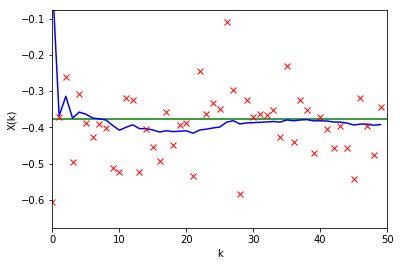

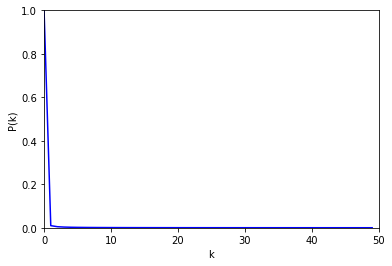

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

'''
ref: Greg Welch and Gary Bishop, 'An Introduction to the Kalman Filter', 2006.
     Estimating a Random Constant : off-line with cv2.KalmanFilter
'''

#1
x = -0.37727 # the truth value

q = 1e-5     # process noise covariance
r = 0.01     # measurement noise covariance, 1, 0.0001

KF = cv2.KalmanFilter(1, 1, 0)             # B = 0
KF.transitionMatrix      = np.ones((1, 1)) # A = 1
KF.measurementMatrix     = np.ones((1, 1)) # H = 1
KF.processNoiseCov       = q * np.eye(1)   # Q
KF.measurementNoiseCov   = r * np.eye(1)   # R

#2 initial value
KF.errorCovPost        = np.ones((1, 1))  # P0 = 1
KF.statePost           = np.zeros((1, 1)) # x0 = 0

N = 50
z = np.random.randn(N, 1)*np.sqrt(r) + x  # measurement
X = [KF.statePost[0,0]]        # initial value
P = [KF.errorCovPost[0,0]]     # initial errorCovPost

#3
for k in range(1, N):
    predict = KF.predict() 
    estimate = KF.correct(z[k])
    X.append(estimate[0,0])        # KF.statePost[0,0]
    P.append(KF.errorCovPost[0,0])
    
#4     
plt.figure(1)      
plt.xlabel('k')
plt.ylabel('X(k)')
plt.axis([0, N, x-3*np.sqrt(r), x+3*np.sqrt(r)])
plt.plot([0, N], [x, x], 'g-')  # the truth value line
plt.plot(X, 'b-')
plt.plot(z, 'rx')

#5
plt.figure(2)      
plt.xlabel('k')
plt.ylabel('P(k)')
plt.axis([0, N, 0, 1.0])
plt.plot(P, 'b-')
plt.show()

### 5.2 cv2.KalmanFilter; random constant estimation, on-line

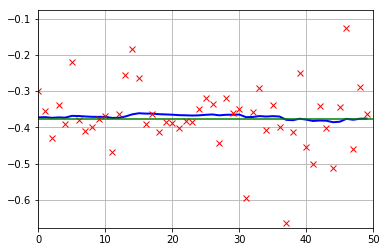

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc
%matplotlib inline

'''
ref: Greg Welch and Gary Bishop, 'An Introduction to the Kalman Filter', 2006.
     Estimating a Random Constant : on-line with cv2.KalmanFilter
'''

#1
x = -0.37727 # the truth value

q = 1e-5     # process noise covariance
r = 0.01     # measurement noise covariance, 1, 0.0001

KF = cv2.KalmanFilter(1, 1, 0)            # B = 0
KF.transitionMatrix    = np.ones((1, 1))  # A = 1
KF.measurementMatrix   = np.ones((1, 1))  # H = 1
KF.processNoiseCov     = q * np.eye(1)    # Q
KF.measurementNoiseCov = r * np.eye(1)    # R

#2 initial value
KF.errorCovPost        = np.ones((1, 1))  # P0 = 1
KF.statePost           = np.zeros((1, 1)) # x0 = 0

N = 50
X = [KF.statePost[0,0]]        # initial value
P = [KF.errorCovPost[0,0]]     # initial errorCovPost

#3
fig = plt.figure()
fig.canvas.set_window_title('Kalman Filter')
ax = plt.axes(xlim=(0, N), ylim=(x-3*np.sqrt(r), x+3*np.sqrt(r)))
ax.grid()
line1, = ax.plot([], [], 'b-', lw=2)
line2, = ax.plot([], [], 'rx')
line3, = ax.plot([0, N], [x, x], 'g-')  # the truth value line
xrange = np.arange(N)
Z = [] # for displaying measurements

#4
def init():
    for k in range(N):
        predict = KF.predict()
        z = np.random.randn(1, 1)*np.sqrt(r) + x  # measurement
        estimate = KF.correct(z[0])
        X.append(estimate[0,0])
        Z.append(z[0][0])
    line1.set_data(xrange, X)
    line2.set_data(xrange, Z)
##  line2.set_data([N-1], z)     
    return line1,line2

#5
def animate(k):
    global X, Z

    predict = KF.predict()
    z = np.random.randn(1, 1)*np.sqrt(r) + x  # measurement
    estimate = KF.correct(z[0])

    X = X[1:N]
    X.append(estimate[0,0])

    Z = Z[1:N]
    Z.append(z[0][0])
    line1.set_data(xrange, X)
    line2.set_data(xrange, Z)
##  line2.set_data([N-1], z)
    return line1,line2

#6
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=25, blit=True)

rc('animation', html='html5')
ani

### 5.3 cv2.KalmanFilter; Mouse Location Tracking

In [10]:
import cv2
import numpy as np

'''
ref: 
http://www.morethantechnical.com/2011/06/17/simple-kalman-filter-for-tracking-using-opencv-2-2-w-code/
'''

#1
def onMouse(event, x, y, flags, param):    
    if event == cv2.EVENT_LBUTTONDBLCLK:
        param[0][:,:] = 0  # clear image
    param[1][0] = x  # mouse point z
    param[1][1] = y
    
#2
frame = np.zeros((512,512,3), np.uint8)
z = np.zeros((2,1), np.float32)  # measurement

cv2.namedWindow('Kalman Fliter')
cv2.setMouseCallback('Kalman Fliter',onMouse, [frame, z])

#3
q = 1e-5   #  process noise covariance
r = 0.01   #  measurement noise covariance, r = 1 
KF = cv2.KalmanFilter(4,2,0)
KF.transitionMatrix = np.array([[1,0,1,0],         
                                [0,1,0,1],
                                [0,0,1,0],
                                [0,0,0,1]], np.float32)   # A
KF.measurementMatrix = np.array([[1,0,0,0],
                                 [0,1,0,0]],np.float32)   # H
KF.processNoiseCov     = q* np.eye(4, dtype=np.float32)   # Q 
KF.measurementNoiseCov = r* np.eye(2, dtype=np.float32)   # R

#4 initial value
KF.errorCovPost  = np.eye(4, dtype=np.float32)        # P0 = I
KF.statePost     = np.zeros((4, 1), dtype=np.float32) # x0 = 0

last_z = z.copy()
last_estimate = KF.statePost.copy()

#5
while True:
    predict  = KF.predict()
    estimate = KF.correct(z)
    
    x1, y1 = np.int0(last_z)
    x2, y2 = np.int0(z)
    cv2.line(frame, (x1, y1),(x2, y2), (0,0,255), 2)
    
    x1, y1, _, _ = np.int0(last_estimate)
    x2, y2, _, _ = np.int0(estimate)
    cv2.line(frame, (x1, y1),(x2, y2), (255,0,0), 2)
    cv2.imshow('Kalman Fliter',frame)
 
    last_z = z.copy()
    last_estimate = estimate.copy()
    
    key = cv2.waitKey(30)
    if key == 27:
        break
        
cv2.destroyAllWindows()

### 5.4 cv2.meanShift + cv2.KalmanFilter (Object tracking) 

In [11]:
import cv2
import numpy as np

#1
roi = None
drag_start = None
mouse_status = 0
tracking_start  = False

def onMouse(event, x, y, flags, param=None): # Set the region of interest by the mouse event.
    global roi
    global drag_start
    global mouse_status
    global tracking_start
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drag_start = (x, y)
        mouse_status = 1
        tracking_start = False
        
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags == cv2.EVENT_FLAG_LBUTTON:
            xmin = min(x, drag_start[0])
            ymin = min(y, drag_start[1])
            xmax = max(x, drag_start[0])
            ymax = max(y, drag_start[1])
            roi = (xmin, ymin, xmax, ymax)
            mouse_status = 2 # dragging
            
    elif event == cv2.EVENT_LBUTTONUP:
        mouse_status = 3 # complete

#2          
cv2.namedWindow('tracking')
cv2.setMouseCallback('tracking', onMouse)

cap = cv2.VideoCapture('./data/ball.wmv')
if (not cap.isOpened()): 
     print('Error opening video')   
        
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                 int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
roi_mask = np.zeros((height, width), dtype=np.uint8)
term_crit = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,10, 1)

#3: Kalman Filter setup
q = 1e-5 # process noise covariance
r = 0.01 # measurement noise covariance, r = 1
dt = 1
KF = cv2.KalmanFilter(4,2,0)
KF.transitionMatrix = np.array([[1,0,dt,0],         
                                [0,1,0,dt],
                                [0,0,1,0],
                                [0,0,0,1]], np.float32)  # A
KF.measurementMatrix = np.array([[1,0,0,0],
                                 [0,1,0,0]],np.float32)  # H

#4
t = 0
while True:
    ret, frame = cap.read()
    if not ret: break
    t+=1
    if t%50 == 0:
        print('t =', t)
    frame2 = frame.copy() # camShift
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,(0, 60, 32),(180,255,255))

    if mouse_status==2:
        x1, y1, x2, y2 = roi
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
    if mouse_status==3:
        print('initialize....')
        mouse_status = 0
        x1, y1, x2, y2 = roi          
        mask_roi = mask[y1:y2, x1:x2]
        hsv_roi  =  hsv[y1:y2, x1:x2]
          
        hist_roi = cv2.calcHist([hsv_roi],[0],mask_roi,[16],[0,180])

        cv2.normalize(hist_roi,hist_roi,0,255,cv2.NORM_MINMAX)
        H1 = hist_roi.copy()
        cv2.normalize(H1,H1,0.0,1.0,cv2.NORM_MINMAX)          
        track_window = (x1, y1, x2-x1, y2-y1) # meanShift
          
#4-1:   Kalman filter initialize    
        KF.processNoiseCov     = q* np.eye(4, dtype=np.float32) # Q        
        KF.measurementNoiseCov = r* np.eye(2, dtype=np.float32) # R
        KF.errorCovPost  = np.eye(4, dtype=np.float32)          # P0 = I

        x, y, w, h = track_window
        KF.statePost=np.array([[x],[y],[0.],[0.]],dtype=np.float32)
        tracking_start = True
               
    if tracking_start:
#4-2
        predict  = KF.predict()

#4-3:   meanShift tracking
        backP = cv2.calcBackProject([hsv],[0],hist_roi,[0,180],1)
        backP &= mask
        
        ret, track_window = cv2.meanShift(backP, track_window, term_crit)
        x,y,w,h = track_window
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255),2)

#4-4:   Kalman correct
        z = np.array([[x],[y]],dtype=np.float32) # measurement
        estimate = KF.correct(z)
        estimate = np.int0(estimate)
          
#4-5         
        x2, y2 = estimate[0][0], estimate[1][0]
        cv2.rectangle(frame, (x2,y2), (x2+w,y2+h), (255,0,0),2)
##      track_window = x2, y2, w, h
          
    cv2.imshow('tracking', frame)
    key = cv2.waitKey(25)
    if key == 27:
        break

if cap.isOpened():
     cap.release()
cv2.destroyAllWindows()

t = 50
initialize....
t = 100
t = 150


### 5.5 cv2.CamShift + cv2.KalmanFilter (Object tracking)

In [12]:
import cv2
import numpy as np

#1
roi  = None
drag_start = None
mouse_status = 0
tracking_start  = False

def onMouse(event, x, y, flags, param=None): # Set the region of interest by the mouse event.
    global roi
    global drag_start
    global mouse_status
    global tracking_start
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drag_start = (x, y)
        mouse_status = 1
        tracking_start = False
        
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags == cv2.EVENT_FLAG_LBUTTON:
            xmin = min(x, drag_start[0])
            ymin = min(y, drag_start[1])
            xmax = max(x, drag_start[0])
            ymax = max(y, drag_start[1])
            roi = (xmin, ymin, xmax, ymax)
            mouse_status = 2 # dragging
            
    elif event == cv2.EVENT_LBUTTONUP:
        mouse_status = 3 # complete

#2          
cv2.namedWindow('tracking')
cv2.setMouseCallback('tracking', onMouse)

cap = cv2.VideoCapture('./data/ball.wmv')
if (not cap.isOpened()):
    print('Error opening video')  
    
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                 int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
roi_mask = np.zeros((height, width), dtype=np.uint8)
term_crit = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,10, 1)

#3: Kalman Filter setup
q = 1e-5 # process noise covariance
r = 0.01 # measurement noise covariance, r = 1
dt = 1
KF = cv2.KalmanFilter(4,2,0)
KF.transitionMatrix = np.array([[1,0,dt,0],         
                                [0,1,0,dt],
                                [0,0,1,0],
                                [0,0,0,1]], np.float32)  # A
KF.measurementMatrix = np.array([[1,0,0,0],
                                 [0,1,0,0]],np.float32)  # H

#4 
t = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    t+=1
    if t%50 == 0:
        print('t =', t)
    frame2 = frame.copy() # camShift
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,(0, 60, 32),(180,255,255))

    if mouse_status==2:
        x1, y1, x2, y2 = roi
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  
        
    if mouse_status==3:
        print('initialize....')
        mouse_status = 0
        x1, y1, x2, y2 = roi          
        mask_roi = mask[y1:y2, x1:x2]
        hsv_roi  =  hsv[y1:y2, x1:x2]
          
        hist_roi = cv2.calcHist([hsv_roi],[0],mask_roi,[16],[0,180])

        cv2.normalize(hist_roi,hist_roi,0,255,cv2.NORM_MINMAX)
        H1 = hist_roi.copy()
        cv2.normalize(H1,H1,0.0,1.0,cv2.NORM_MINMAX)          
        track_window = (x1, y1, x2-x1, y2-y1) # meanShift
          
#4-1:   Kalman filter initialize    
        KF.processNoiseCov     = q* np.eye(4, dtype=np.float32)   # Q         
        KF.measurementNoiseCov = r* np.eye(2, dtype=np.float32)   # R
        KF.errorCovPost  = np.eye(4, dtype=np.float32)            # P0 = I

        x, y, w, h = track_window
        cx = x + w/2
        cy = y + h/2
        KF.statePost=np.array([[cx],[cy],[0.],[0.]],dtype=np.float32)
        tracking_start = True
        
    if tracking_start:
#4-2
        predict = KF.predict()

#4-3:   CamShift tracking
        backP = cv2.calcBackProject([hsv],[0],hist_roi,[0,180],1)
        backP &= mask
         
        track_box,track_window=cv2.CamShift(backP, track_window, term_crit)

        cv2.ellipse(frame, track_box, (0, 0, 255), 2)
        cx, cy = track_box[0]
        cv2.circle(frame, (round(cx),round(cy)), 5, (0,0,255), -1)
##      pts = cv2.boxPoints(track_box)
##      pts = np.int0(pts) # np.int32
##      dst = cv2.polylines(frame,[pts],True, (0, 0, 255),2)

#4-4:   Kalman correct
        z = np.array([[cx],[cy]],dtype=np.float32) # measurement
        estimate = KF.correct(z)
        estimate = np.int0(estimate)          
#4-5         
        cx2, cy2 = estimate[0][0], estimate[1][0]  
        track_box2 = ((cx2, cy2), track_box[1], track_box[2])
        cv2.ellipse(frame, track_box2, (255, 0, 0), 2)          
        cv2.circle(frame, (cx2,cy2), 5, (255,0,0), -1)
        
    cv2.imshow('tracking', frame)
    key = cv2.waitKey(25)
    if key == 27:
        break

if cap.isOpened():
     cap.release()
cv2.destroyAllWindows()

t = 50
initialize....
t = 100
t = 150


## 6. Feature matching in video

### 6.1 FlannBasedMatcher using SURF Features

In [13]:
import cv2
import numpy as np

#1
src1 = cv2.imread('./data/book3.jpg')
img1= cv2.cvtColor(src1,cv2.COLOR_BGR2GRAY)

surF = cv2.xfeatures2d.SURF_create()
kp1, des1 = surF.detectAndCompute(img1, None)
flan = cv2.FlannBasedMatcher_create()

#2
cap = cv2.VideoCapture('./data/book3.mp4')
##cap = cv2.VideoCapture('http://172.30.1.28:4747/mjpegfeed') # droid cam

frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
              int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print("frame_size =", frame_size)

#3
nndrRatio = 0.65  # 0.45
h, w = img1.shape
t = 0

while True:    
    retval, frame = cap.read() # get frame
    if not retval:
        break
    t+=1
    if t%50 == 0:
        print('t =', t)
#3-1
    src2 = frame.copy()
    img2 = cv2.cvtColor(src2,cv2.COLOR_BGR2GRAY)
    kp2, des2 = surF.detectAndCompute(img2, None)
    matches = flan.knnMatch(des1,des2, k=2)

#3-2
    good_matches = [f1 for f1, f2 in matches
                       if f1.distance < nndrRatio*f2.distance]
    dst = cv2.drawMatches(src1,kp1,src2,kp2, good_matches, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    
    if len(good_matches) < 5:
        print('sorry, too small good matches')
        cv2.imshow('dst',  dst)
        key = cv2.waitKey(50)
        if key == 27: # Esc
            break
        continue
        
#3-3    
    src1_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches])
    src2_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches])
    H, mask = cv2.findHomography(src1_pts,src2_pts, cv2.RANSAC, 2.0)
    mask_matches = mask.ravel().tolist() # list(mask.flatten())

#3-4
    if H is None:
        print('sorry, no H')
        continue
    pts  = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    pts2 = cv2.perspectiveTransform(pts, H)
    src2 = cv2.polylines(src2,[np.int32(pts2)],True,(255,0, 0),2)
            
    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = None,
                       matchesMask = mask_matches, flags = 2)                 
    dst = cv2.drawMatches(src1,kp1,src2,kp2, good_matches, None,**draw_params)
    cv2.imshow('dst', dst)
    
    key = cv2.waitKey(25)
    if key == 27: # Esc
        break
    
cap.release()
cv2.destroyAllWindows()

frame_size = (640, 480)
t = 50


## 7. OpenCV tracker

In [14]:
'''
In case of GOTURN,
you need the pretrained caffe model: 'goturn.prototxt', 'goturn.caffemodel'
in
ref1: https://github.com/Mogball/goturn-files
ref2: https://github.com/Auron-X/GOTURN_Training_Toolkit
'''

import cv2
import numpy as np

#1
roi = None
drag_start = None
mouse_status = 0
tracking_start = False
def onMouse(event, x, y, flags, param = None): # Set the region of interest by the mouse event.
    global roi
    global drag_start
    global mouse_status
    global tracking_start
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drag_start = (x, y)
        mouse_status = 1
        tracking_start = False
        
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags == cv2.EVENT_FLAG_LBUTTON:
            xmin = min(x, drag_start[0])
            ymin = min(y, drag_start[1])
            xmax = max(x, drag_start[0])
            ymax = max(y, drag_start[1])
            roi = (xmin, ymin, xmax, ymax)
            mouse_status = 2 # dragging
            
    elif event == cv2.EVENT_LBUTTONUP:
        mouse_status = 3 # complete

#2
def createTracker():
##  tracker = cv2.TrackerBoosting_create()
##  tracker = cv2.TrackerKCF_create()
##  tracker = cv2.TrackerMIL_create()
##  tracker = cv2.TrackerMOSSE_create()
##  tracker = cv2.TrackerMedianFlow_create()
##  tracker = cv2.TrackerTLD_create()    
    tracker = cv2.TrackerGOTURN_create()
    return tracker

#3          
cv2.namedWindow('tracking')
cv2.setMouseCallback('tracking', onMouse)

cap = cv2.VideoCapture('./data/ball.wmv')
##cap = cv2.VideoCapture('./data/vtest.avi')
if (not cap.isOpened()): 
    print('Error opening video')
    
height, width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                 int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
tracker = None

#4 
while True:
    ret, frame = cap.read()
    if not ret:
        break

    if mouse_status == 2:
        x1, y1, x2, y2 = roi
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  
        
    if mouse_status == 3:
        print('initialize....')
        mouse_status = 0
        track_box = (roi[0], roi[1], roi[2]-roi[0], roi[3]-roi[1])
        if tracker != None:
            tracker.clear()
            del tracker
        tracker = createTracker()
        tracking_start = tracker.init(frame, track_box)

    if tracking_start:
        ret, track_box = tracker.update(frame)
##      print("track_box=", track_box)
        if ret:    # Tracking success
            x, y, w, h = track_box
            p1 = (int(x), int(y))
            p2 = (int(x + w), int(y + h))
            cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
            
    cv2.imshow('tracking', frame)
    key = cv2.waitKey(30)
    if key == 27:
        break
        
if cap.isOpened():
    cap.release()
cv2.destroyAllWindows()

initialize....
initialize....
